# Hands-On Deep Learning modelo LSTM para series de tiempo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/lstm-time-series.ipynb)

En este notebook vamos a usar capas LSTM o Long-Short Term Memory para casos de series de tiempo. Vamos a continuar con el mismo dataset de la lección anterior con el fin de tener una visión holística de como se comparan las diferentes técnicas que hemos visto hasta ahora para el mismo problema. 

## Serie de tiempo del clima del laboratorio Max Planck
Para este notebook vamos a trabajar sobre una serie de datos climáticos cuyo dataset pueden encontrar aquí: https://www.kaggle.com/datasets/arashnic/max-planck-weather-dataset/data. Debido a que el dataset son 42MB y requiere autenticación en kaggle para descargar, esto deberán hacerlo manualmente antes de continuar con el notebook.

El objetivo de este caso es modelar la serie de tiempo de la temperatura atmosférica en grados centigrados. Para ello, contamos no solo con datos desde el 2009 al 2016 sobre la temperatura misma sino de otras mediciones como la presión atmosférica, presión de vapor, humedad, entre otros. Los datos fueron tomados especificamente en la estación del clima Beuternberg

### Enlaces de interés
- [Max-Planck Institut](https://mpimet.mpg.de/en/research/observations)
- [Max-Planck Institut - Weather Station](https://www.bgc-jena.mpg.de/wetter/)
- [Weather Station Beutenberg](https://www.bgc-jena.mpg.de/wetter/towercam.html)
- [Beutenberg Campus](https://maps.app.goo.gl/fGJX1T9bjTJhueqJ9)

In [1]:
import pkg_resources
import warnings
import os

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

datasets_path = './datasets/' if IN_COLAB else '../datasets'
# Para guardar modelos entrenados y re-utilizarlos luego
models_path = os.path.join(os.getcwd(), 'models')
os.makedirs(models_path, exist_ok=True)

In [2]:
!test '{IN_COLAB}' = 'True' && wget https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%201%20-%20Time%20Series/requirements.txt  && pip install -r requirements.txt

In [3]:
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/4j4r2tes -O lstm-ts.zip && unzip lstm-ts.zip
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/3aamktz3 -O datasets.zip && unzip datasets.zip
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/39t3duhu -O sarimax.zip && unzip sarimax.zip

Primero, vamos a observar los datos y hacernos una idea de con que estamos lidiando

In [4]:
import pandas as pd
import numpy as np

# El dataset cuenta con temperatura en grados Kelvin también
# Pero no queremos incluir esta columna porque está midiendo exactamente lo mismo
columns = ['T (degC)', 'p (mbar)', 'VPact (mbar)', 'sh (g/kg)', 'Tdew (degC)', 'H2OC (mmol/mol)']
# Cambiar según la localización del archivo.
dataset = pd.read_csv(os.path.join(datasets_path, 'max_planck_weather_ts.csv'))[columns]

dataset.head(15)

,T (degC),p (mbar),VPact (mbar),sh (g/kg),Tdew (degC),H2OC (mmol/mol)
0,-8.02,996.52,3.11,1.94,-8.90,3.12
1,-8.41,996.57,3.02,1.89,-9.28,3.03
2,-8.51,996.53,3.01,1.88,-9.31,3.02
3,-8.31,996.51,3.07,1.92,-9.07,3.08
4,-8.27,996.51,3.08,1.92,-9.04,3.09
5,-8.05,996.50,3.14,1.96,-8.78,3.15
6,-7.62,996.50,3.26,2.04,-8.30,3.27
7,-7.62,996.50,3.25,2.03,-8.36,3.26
8,-7.91,996.50,3.15,1.97,-8.73,3.16
9,-8.43,996.53,3.00,1.88,-9.34,3.02


## Train-test split
Como este es un experimento un poco más realista, vamos a separar los conjuntos de datos en train y test. Como ya debemos saber, el conjunto de entrenamiento es exclusivamente para ese fin y el conjunto de prueba únicamente debemos usarlo para validar el modelo ante información no vista durante el entrenamiento y así poner a prueba su capacidad predictiva.

Como esto es una serie de tiempo, no podemos hacer un random sample ya que romperíamos la estructura secuencial de los datos. Asi que vamos a hacer algo más simple y dividir el conjunto en un punto particular. Vamos a trabajar con un train set correspondiente al 90% del conjunto original.

In [5]:
train_chunk = int(dataset.shape[0] * 0.9)

# Solo nos interesa trabajar con estas columnas por ahora
columns = ['T (degC)', 'p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']

# Necesitamos trabajar solo con datos informados, por lo que debemos descartar registros que no los tengan
train_set = dataset.iloc[:train_chunk][columns].dropna()
test_set = dataset.iloc[train_chunk:][columns].dropna()

## Baseline - Modelo SARIMAX
Preparamos un modelo SARIMAX como en la lección anterior para tenerlo como comparativa.

In [6]:
%%time
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model_path = os.path.join(models_path, 'sarimax_model.pkl')
relative_path = os.path.relpath(sarimax_model_path, os.getcwd())
if os.path.exists(sarimax_model_path):
    with open(sarimax_model_path, 'rb') as f:
        sarimax_model = pickle.load(f)
    
    print(f'Usando un modelo pre-entrenado en {relative_path}')
else:
    # Trabajaremos con los últimos 200k pasos de tiempo solamente.
    endog = train_set.loc[len(train_set)-200000:, 'T (degC)']
    exog = train_set.loc[len(train_set)-200000:, ['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']].values

    sarimax = SARIMAX(endog, exog, order=(1, 1, 2), seasonal_order=(1, 1, 2, 4), simple_differencing=False)
    sarimax_model = sarimax.fit(disp=False)
    
    sarimax_model.save(sarimax_model_path)

    print(f'Guardando modelo en {relative_path}')

print(sarimax_model.summary())

Usando un modelo pre-entrenado en models/sarimax_model.pkl
                                     SARIMAX Results                                     
Dep. Variable:                          T (degC)   No. Observations:               200000
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 4)   Log Likelihood               46387.378
Date:                           Sun, 03 Mar 2024   AIC                         -92754.757
Time:                                   15:48:12   BIC                         -92652.696
Sample:                                        0   HQIC                        -92724.718
                                        - 200000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2265      0.002   -115.573      0.000      -0.

In [7]:
from sklearn.metrics import mean_squared_error

test_endog = test_set['T (degC)']
test_exog = test_set[['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)']]

sarimax_preds = sarimax_model.get_forecast(steps=test_endog.shape[0], exog=test_exog).predicted_mean

validation = pd.DataFrame({'data': test_endog.values, 'prediction': sarimax_preds.values})

mse = mean_squared_error(validation['data'], validation['prediction'])
print(f"MSE Modelo SARIMAX: {mse:.4f}")
# Ya no necesitamos mas el modelo sarimax en memoria
del sarimax_model

MSE Modelo SARIMAX: 75.0673


## Modelo LSTM simple

![](../assets/TS-SimpleLSTM.drawio-wbg.png)

Ahora vamos a entrenar un modelo LSTM simple el cual consite en sencillamente agregar una capa LSTM al modelo MLP anterior, la cual va a actuar como featurizer y va a extraer features relevantes de la serie los cuales son los que finalmente van a pasar a las capas densas para hacer las predicciones.

El proceso de entrenamiento es igual que en el modelo anterior por lo que todo lo demás permanece igual.

In [8]:
%%time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pytorch_lightning import LightningModule, Trainer
from typing import List, Tuple
from torch.nn import functional as F
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split


class TimeSeriesDataset(Dataset):
    """Time Series Dataset.
    Define un pytorch dataset desde un pandas dataframe.
    Asume que el dataframe provisto es una serie donde
    cada fila corresponde a un paso de tiempo t y cada
    columna son el vector a procesar.
    """
    def __init__(self, 
                 dataframe: pd.DataFrame,
                 target_col: str,
                 feature_cols:  List[str],
                 sequence_length: int = 10) -> None:
        super().__init__()
        self._dataframe = dataframe.reset_index(drop=True)
        self.sequence_length = sequence_length
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.scaler = StandardScaler()
        self.cache = {}

    
    def __len__(self):
        # Porque a partir de n - sequence length, no se podrán extraer más secuencias.
        return len(self._dataframe) - self.sequence_length
    
    def __getitem__(self, index) -> Tuple[torch.Tensor]:
        if index in self.cache:
            return self.cache[index]

        start_idx = index
        end_idx = index + self.sequence_length - 1

        # Extraemos las secuencias, el valor objetivo debe estar incluido en la secuencia.
        sequence = self._dataframe.loc[start_idx:end_idx, [self.target_col] + self.feature_cols].values
        # Aplicamos escala si es necesario
        sequence = self.scaler.fit_transform(sequence)
        
        # Extraemos el objetivo
        target = self._dataframe.loc[end_idx, self.target_col]

        # Convertimos a tensores de pytorch
        sequence = torch.tensor(sequence, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        self.cache[index] = (sequence, target)

        return sequence, target


sequence_length = 200
train_dataset = TimeSeriesDataset(
    train_set[columns], 
    target_col='T (degC)', 
    feature_cols=['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)'],
    sequence_length = sequence_length
    )

# Este split puede tomar ~15min
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, train_size=0.8)

# Creamos los dataloaders para el entrenamiento de la red
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=6)

CPU times: user 22min 15s, sys: 3.98 s, total: 22min 19s
Wall time: 22min 24s


### Definición del modelo y entrenamiento

En esta implementación en particular, vamos a tomar solamente el último elemento de la secuencia tras pasar por la capa LSTM junto con el *hidden state* de la última capa LSTM. La intuición de esta decisión es que el último elemento de la serie, tras pasar por la capa, debería contener en si mismo toda la información necesaria de las interacciones de sus pasos anteriores puesto que así está diseñada la celda. Además, el hidden state también trae consigo información relevante de la capa LSTM en si, por lo que debería traer consigo información adicional de la secuencia completa.

Esta no es la única forma de hacerlo, también podríamos descartar completamente el hidden state y operar completamente con el output de la capa LSTM. La decisión de si hacer lo uno o lo otro recae en el tipo de problema y lo que más nos interesa lograr. En los problemas de regresión, como este, nos interesa el paso inmediatamente siguiente, por lo que una vez la secuencia ha sido condensada en el último paso + el hidden state, podríamos descartar el resto de la información.

Sin embargo, es posible hacerlo del otro modo, pero sería necesario ajustsar las dimensiones de entrada de la capa densa para poder que se ajuste al nuevo input.

In [9]:
%%time
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class SimpleLSTM(LightningModule):

    def __init__(self, 
                 input_size: int, 
                 output_size: int,
                 sequence_length: int = 10,
                 lstm_hidden_size: int = 128,
                 lstm_layers: int = 1
        ):
        super(SimpleLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_layers=lstm_layers, batch_first=True)

        self.fc_block = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

        self.hparams['lstm'] = str(self.lstm)
        self.hparams['fc_block'] = str(self.fc_block)
        self.save_hyperparameters()

    def forward(self, x):
        # in: x.shape = (batch_size, input_size) ->
        x, (hidden_state, cell_state) = self.lstm(x)
        # -> out: 
        # - x.shape = (batch_size, sequence_length, lstm_hidden_size)
        # - hidden_state.shape = (lstm_layers, batch_size, lstm_hidden_state)

        x = x[:, -1, :]
        # -> out: 
        # - x.shape = (batch_size, lstm_hidden_size), hemos seleccionado el último time step


        # in: hidden_state.shape = (last_layer, batch_size, lstm_hidden_size)
        concat_features = torch.cat([x, hidden_state[-1, :, :]], dim=1)
        # -> out:
        # - concat_features.shape = (batch_size, lstm_hidden_size + lstm_hidden_size)
        
        return self.fc_block(concat_features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        self.log('test_loss', loss)

    def predict_step(self, batch):
        x, y = batch
        return torch.cat([self(x), y.unsqueeze(-1)], axis=-1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

lstm_model = SimpleLSTM(4, 1, lstm_layers=2, sequence_length=sequence_length)

tb_logger = TensorBoardLogger('tb_logs', name='SimpleLSTM')
trainer = Trainer(max_epochs=10, devices=1, logger=tb_logger, callbacks=[EarlyStopping(monitor='val_loss', mode='min')])
trainer.fit(lstm_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | lstm     | LSTM       | 200 K 
1 | fc_block | Sequential | 41.2 K
----------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.968     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 296/296 [00:42<00:00,  6.91it/s, v_num=10, train_loss=15.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 296/296 [00:42<00:00,  6.91it/s, v_num=10, train_loss=15.40]
CPU times: user 6min 44s, sys: 12.3 s, total: 6min 57s
Wall time: 7min 9s


Hemos entrenado el modelo y en principio, hemos alcanzado una pérdida por debajo de $1$ en el conjunto de entrenamiento. Esto podría ser buena señal, pero siempre hay que validar contra el conjunto de prueba y posteriormente haciendo predicciones.

In [10]:
%load_ext tensorboard

In [11]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 289111), started 3 days, 7:47:14 ago. (Use '!kill 289111' to kill it.)

Y ahora observemos el rendimiento en el conjunto de prueba.

In [12]:
lstm_model.eval()
test_dataset = TimeSeriesDataset(
    test_set[columns], 
    target_col='T (degC)', 
    feature_cols=['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)'],
    sequence_length = sequence_length
    )
test_loader = DataLoader(test_dataset, batch_size=512)
result = trainer.test(dataloaders=test_loader)

Restoring states from the checkpoint path at tb_logs/SimpleLSTM/version_10/checkpoints/epoch=9-step=2960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tb_logs/SimpleLSTM/version_10/checkpoints/epoch=9-step=2960.ckpt


Testing DataLoader 0: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            32.14357376098633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Resultados interesantes

Observamos que en comparación con la pérdida en entrenamiento esta es significativamente mayor, lo cual sugiere que el modelo está memorizando los datos, es decir, estaría haciendo overfitting. Ya sabemos que esto lo podríamos tratar con regularización en la red y/o en la función de pérdida.

También, desde el punto de vista de la comparación con el modelo MLP, este no es significativamente mejor. Ahora será necesario analizar los resultados de las predicciones.


| Modelo  | MSE Loss|
| ------- | ------- |
| SARIMAX | 75.0673 |
| MLP     | 30.8823 |
| LSTM    | 32.1435 |


## Pronósticos

Restoring states from the checkpoint path at tb_logs/SimpleLSTM/version_10/checkpoints/epoch=9-step=2960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tb_logs/SimpleLSTM/version_10/checkpoints/epoch=9-step=2960.ckpt


Predicting DataLoader 0: 100%|██████████| 82/82 [00:02<00:00, 38.64it/s]


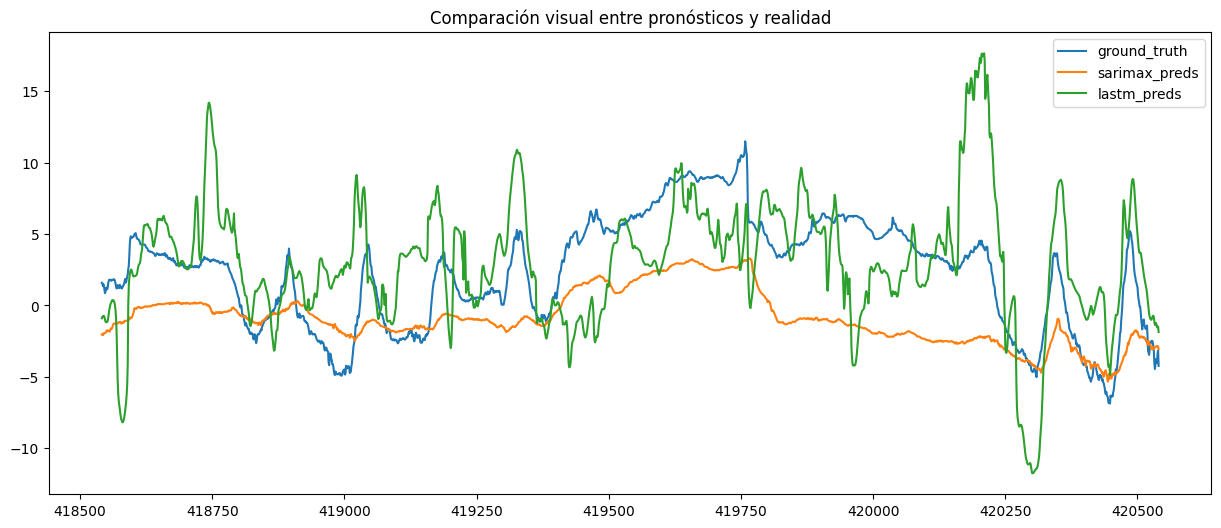

In [13]:
import matplotlib.pyplot as plt

lstm_batched_preds = trainer.predict(dataloaders=test_loader)
lstm_preds = np.concatenate([b.numpy() for b in lstm_batched_preds])

steps = 2000
visual_check = pd.DataFrame({
    'ground_truth': lstm_preds[-steps:, 1],
    'sarimax_preds': sarimax_preds[-steps-10:][:-10],
    'lastm_preds': lstm_preds[-steps:, 0]    
})

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
visual_check.plot.line(ax=ax)
plt.title("Comparación visual entre pronósticos y realidad")
plt.show()

Observemos que en comparación con el modelo MLP, el modelo LSTM se asemeja mucho más a la serie original, los comportamientos ya no son tan erraticos e incluso logra capturar las tendencias de la serie. Salvo en unos puntos particulares, el modelo LSTM es un mejor contendor contra el modelo clásico.

## Conclusiones
- Siempre es bueno analizar los resultados tanto de forma cuantitativa como cualitativa. Hemos visto que la métrica entre MLP y LSTM no era significativamente distante, sin embargo los pronósticos con LSTM son mucho mejores.
- Aún asi, vale la pena plantearse los pros y contras entre diferentes técnicas. 
  - Por un lado, tenemos una técnica sencilla, simple y efectiva, que da buenos resultados *incluso* con la limitante de la cantidad de datos.
  - Por otro lado, tenemos otra técnica que nos puede servir para procesar un volumen de datos significativamente mayor y con un potencial de dimensionalidad superior, lo cual nos serviría para trabajar problemas mucho más complejos.